In [1]:
import json
import logging
from sqlalchemy import Column, Integer, String, Float, DateTime, Boolean, func
from iotfunctions import bif
from iotfunctions.metadata import EntityType
from iotfunctions.db import Database
from iotfunctions.base import BaseTransformer
from iotfunctions.bif import EntityDataGenerator
from custom import settings
import datetime as dt

import pandas as pd
import numpy as np

from watson_machine_learning_client import WatsonMachineLearningAPIClient
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.pipeline import Pipeline
import sklearn
import time

import os
import json


2020-10-31 13:19:33,260 - root - INFO - 
Logging Set To: DEBUG


Loading WML Environment Variables
Environment Variables Loaded Successfully


In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

%matplotlib notebook


2020-10-31 13:19:46,855 - matplotlib.pyplot - DEBUG - 
Loaded backend module://ipykernel.pylab.backend_inline version unknown.

2020-10-31 13:19:46,860 - matplotlib.pyplot - DEBUG - 
Loaded backend module://ipykernel.pylab.backend_inline version unknown.

2020-10-31 13:19:46,888 - matplotlib.pyplot - DEBUG - 
Loaded backend nbAgg version unknown.


In [3]:
# Load .env file
from dotenv import load_dotenv
env_path = 'custom/.env'
load_dotenv(dotenv_path=env_path)

True

In [4]:
os.environ.keys()

KeysView(environ({'TERM_PROGRAM': 'Apple_Terminal', 'SHELL': '/bin/zsh', 'TERM': 'xterm-color', 'TMPDIR': '/var/folders/_m/t_dpdfz12qnfybt3blpwpt1c0000gn/T/', 'CONDA_SHLVL': '1', 'CONDA_PROMPT_MODIFIER': '(base) ', 'TERM_PROGRAM_VERSION': '433', 'TERM_SESSION_ID': '88D6BF5A-8FBF-464A-82B7-D73A347AC2FC', 'ZSH': '/Users/marcogeiger/.oh-my-zsh', 'USER': 'marcogeiger', 'CONDA_EXE': '/Users/marcogeiger/opt/anaconda3/bin/conda', 'SSH_AUTH_SOCK': '/private/tmp/com.apple.launchd.vIBY4SqhEF/Listeners', 'PAGER': 'cat', 'LSCOLORS': 'Gxfxcxdxbxegedabagacad', '_CE_CONDA': '', 'PATH': '/Users/marcogeiger/.pyenv/shims:/Users/marcogeiger/.poetry/bin:/Users/marcogeiger/.pyenv/shims:/Users/marcogeiger/opt/anaconda3/bin:/Users/marcogeiger/opt/anaconda3/condabin:/anaconda3/bin:/Library/Frameworks/Python.framework/Versions/3.7/bin:/Library/Frameworks/Python.framework/Versions/3.7/bin:/Users/marcogeiger/.poetry/bin:/Library/Frameworks/Python.framework/Versions/3.7/bin:/usr/local/bin:/usr/bin:/bin:/usr/sbin:

In [5]:
# USER PREREQ #
# Set path to Monitor credentials file in .env
if 'MONITOR_CREDENTIALS_PATH' in os.environ.keys():
    creds_file = os.environ['MONITOR_CREDENTIALS_PATH']
else:
    creds_file = "./credentials/monitor-demo-creds.json"
    
with open(creds_file, 'r') as f: 
    credentials = json.loads(f.read())

db = Database(credentials = credentials)
db_schema = "BLUADMIN" #  set if you are not using the default

# USER PREREQ #
# Set the entity name you'd like to retrieve data from
if 'ENTITY_NAME' in os.environ.keys():
    entity_name = os.environ["ENTITY_NAME"]
else:
    entity_name = "IOT_SATELLITE"

#df = db.read_table(table_name=entity_name, schema=db_schema)
#df


2020-10-31 13:19:46,916 - iotfunctions.db - DEBUG - 
file name db => /Users/marcogeiger/GitHub/Satellite_AnomalyDetection/db2_certificate.pem;

2020-10-31 13:19:46,917 - iotfunctions.db - DEBUG - 
created a CosClient object

2020-10-31 13:19:46,966 - iotfunctions.db - DEBUG - 
Set isolation

2020-10-31 13:19:49,888 - iotfunctions.db - DEBUG - 
Isolation level set

2020-10-31 13:19:49,888 - iotfunctions.db - DEBUG - 
Database connection via SqlAlchemy established.

2020-10-31 13:19:50,720 - iotfunctions.db - DEBUG - 
Native database connection to DB2 established.

2020-10-31 13:19:52,680 - iotfunctions.db - DEBUG - 
http request successful. status 200


In [5]:
df = pd.read_csv("training_data.csv")
df

CPU_Current  CPU_Voltage  CPU_Power  XTorquer_Voltage  XTorquer_Current  \
0       0.026855      3.75000      100.7            2.8750          0.125000   
1       0.043945      3.75000      164.8            0.5000          0.000000   
2       0.040527      4.21875      171.0            2.3125          0.078125   
3       0.123047      4.09375      503.7            0.0000          0.015625   
4       0.046387      4.59375      213.1            0.0000          0.015625   
..           ...          ...        ...               ...               ...   
394     0.020020      4.84375       97.0            1.3750          0.046875   
395     0.023926      3.96875       95.0            2.8750          0.125000   
396     0.034668      3.62500      125.7            2.9375          0.125000   
397     0.043945      3.53125      155.2            1.4375          0.046875   
398     0.030762      4.62500      142.3            0.0625          0.015625   

     XTorquer_Power  YTorquer_Voltage  YTorquer_Current  YTorquer_Power  
0             359.4            2.8750          0.125000           359.4  
1               0.0            2.2500          0.093750           210.9  
2             180.7            2.3125          0.078125           180.7  
3               0.0            0.0000          0.015625             0.0  
4               0.0            0.0000          0.015625             0.0  
..              ...               ...               ...             ...  
394            64.5            0.1875          0.046875             8.8  
395           359.4            3.0000          0.093750           281.2  
396           367.2            3.0625          0.093750           287.1  
397            67.4            2.9375          0.093750           275.4  
398             1.0            0.0000          0.015625             0.0  

[399 rows x 9 columns]

In [6]:
 #If there are columns with NaN value, we delete them
 df.dropna(inplace=True)
 df

CPU_Current  CPU_Voltage  CPU_Power  XTorquer_Voltage  XTorquer_Current  \
0       0.026855      3.75000      100.7            2.8750          0.125000   
1       0.043945      3.75000      164.8            0.5000          0.000000   
2       0.040527      4.21875      171.0            2.3125          0.078125   
3       0.123047      4.09375      503.7            0.0000          0.015625   
4       0.046387      4.59375      213.1            0.0000          0.015625   
..           ...          ...        ...               ...               ...   
394     0.020020      4.84375       97.0            1.3750          0.046875   
395     0.023926      3.96875       95.0            2.8750          0.125000   
396     0.034668      3.62500      125.7            2.9375          0.125000   
397     0.043945      3.53125      155.2            1.4375          0.046875   
398     0.030762      4.62500      142.3            0.0625          0.015625   

     XTorquer_Power  YTorquer_Voltage  YTorquer_Current  YTorquer_Power  
0             359.4            2.8750          0.125000           359.4  
1               0.0            2.2500          0.093750           210.9  
2             180.7            2.3125          0.078125           180.7  
3               0.0            0.0000          0.015625             0.0  
4               0.0            0.0000          0.015625             0.0  
..              ...               ...               ...             ...  
394            64.5            0.1875          0.046875             8.8  
395           359.4            3.0000          0.093750           281.2  
396           367.2            3.0625          0.093750           287.1  
397            67.4            2.9375          0.093750           275.4  
398             1.0            0.0000          0.015625             0.0  

[399 rows x 9 columns]

In [64]:
#Rename columns, if necessary
df = df.rename(columns={'satellite_y_torquer_power': 'ytorquer_power', 'satellite_x_torquer_current':'xtorquer_current',
       'satellite_x_torquer_voltage': 'xtorquer_voltage', 'satellite_y_torquer_current': 'ytorquer_current', 'satellite_x_torquer_power':'xtorquer_power','satellite_y_torquer_voltage':'ytorquer_voltage',
                       'satellite_cpu_current':'cpu_current', 'satellite_cpu_power':'cpu_power', 'satellite_cpu_voltage':'cpu_voltage'})
df

CPU_Current  CPU_Voltage  CPU_Power  XTorquer_Voltage  XTorquer_Current  \
0       0.026855      3.75000      100.7            2.8750          0.125000   
1       0.043945      3.75000      164.8            0.5000          0.000000   
2       0.040527      4.21875      171.0            2.3125          0.078125   
3       0.123047      4.09375      503.7            0.0000          0.015625   
4       0.046387      4.59375      213.1            0.0000          0.015625   
..           ...          ...        ...               ...               ...   
394     0.020020      4.84375       97.0            1.3750          0.046875   
395     0.023926      3.96875       95.0            2.8750          0.125000   
396     0.034668      3.62500      125.7            2.9375          0.125000   
397     0.043945      3.53125      155.2            1.4375          0.046875   
398     0.030762      4.62500      142.3            0.0625          0.015625   

     XTorquer_Power  YTorquer_Voltage  YTorquer_Current  YTorquer_Power  
0             359.4            2.8750          0.125000           359.4  
1               0.0            2.2500          0.093750           210.9  
2             180.7            2.3125          0.078125           180.7  
3               0.0            0.0000          0.015625             0.0  
4               0.0            0.0000          0.015625             0.0  
..              ...               ...               ...             ...  
394            64.5            0.1875          0.046875             8.8  
395           359.4            3.0000          0.093750           281.2  
396           367.2            3.0625          0.093750           287.1  
397            67.4            2.9375          0.093750           275.4  
398             1.0            0.0000          0.015625             0.0  

[399 rows x 9 columns]

In [7]:
df.columns= df.columns.str.lower()
df

cpu_current  cpu_voltage  cpu_power  xtorquer_voltage  xtorquer_current  \
0       0.026855      3.75000      100.7            2.8750          0.125000   
1       0.043945      3.75000      164.8            0.5000          0.000000   
2       0.040527      4.21875      171.0            2.3125          0.078125   
3       0.123047      4.09375      503.7            0.0000          0.015625   
4       0.046387      4.59375      213.1            0.0000          0.015625   
..           ...          ...        ...               ...               ...   
394     0.020020      4.84375       97.0            1.3750          0.046875   
395     0.023926      3.96875       95.0            2.8750          0.125000   
396     0.034668      3.62500      125.7            2.9375          0.125000   
397     0.043945      3.53125      155.2            1.4375          0.046875   
398     0.030762      4.62500      142.3            0.0625          0.015625   

     xtorquer_power  ytorquer_voltage  ytorquer_current  ytorquer_power  
0             359.4            2.8750          0.125000           359.4  
1               0.0            2.2500          0.093750           210.9  
2             180.7            2.3125          0.078125           180.7  
3               0.0            0.0000          0.015625             0.0  
4               0.0            0.0000          0.015625             0.0  
..              ...               ...               ...             ...  
394            64.5            0.1875          0.046875             8.8  
395           359.4            3.0000          0.093750           281.2  
396           367.2            3.0625          0.093750           287.1  
397            67.4            2.9375          0.093750           275.4  
398             1.0            0.0000          0.015625             0.0  

[399 rows x 9 columns]

In [8]:
class InputColumns(Exception):
    """
    Raised when Input Columns are not present.
    """
    pass

## EXPLORE DATA
# Define input columns (Make sure they match your asset input names)
s = lambda x: x.strip()
if 'INPUT_COLUMNS' in os.environ.keys():
    columns = list(map(s, os.environ['INPUT_COLUMNS'].split(',')))
else:
    raise InputColumns

#copy relevant columns into new dataframe
s_df = df[columns].copy()
s_df

xtorquer_current  xtorquer_power  xtorquer_voltage  ytorquer_current  \
0            0.125000           359.4            2.8750          0.125000   
1            0.000000             0.0            0.5000          0.093750   
2            0.078125           180.7            2.3125          0.078125   
3            0.015625             0.0            0.0000          0.015625   
4            0.015625             0.0            0.0000          0.015625   
..                ...             ...               ...               ...   
394          0.046875            64.5            1.3750          0.046875   
395          0.125000           359.4            2.8750          0.093750   
396          0.125000           367.2            2.9375          0.093750   
397          0.046875            67.4            1.4375          0.093750   
398          0.015625             1.0            0.0625          0.015625   

     ytorquer_power  ytorquer_voltage  cpu_current  cpu_power  cpu_voltage  
0             359.4            2.8750     0.026855      100.7      3.75000  
1             210.9            2.2500     0.043945      164.8      3.75000  
2             180.7            2.3125     0.040527      171.0      4.21875  
3               0.0            0.0000     0.123047      503.7      4.09375  
4               0.0            0.0000     0.046387      213.1      4.59375  
..              ...               ...          ...        ...          ...  
394             8.8            0.1875     0.020020       97.0      4.84375  
395           281.2            3.0000     0.023926       95.0      3.96875  
396           287.1            3.0625     0.034668      125.7      3.62500  
397           275.4            2.9375     0.043945      155.2      3.53125  
398             0.0            0.0000     0.030762      142.3      4.62500  

[399 rows x 9 columns]

## 3. Visualize Data

Explore CPU Data by Visualizing it - We start with the CPU Data

In [67]:
#prepare CPU data for visualization
cpu_df = df[["cpu_voltage", "cpu_power", "cpu_current"]].copy()
cpu_df

cpu_voltage  cpu_power  cpu_current
0        3.75000      100.7     0.026855
1        3.75000      164.8     0.043945
2        4.21875      171.0     0.040527
3        4.09375      503.7     0.123047
4        4.59375      213.1     0.046387
..           ...        ...          ...
394      4.84375       97.0     0.020020
395      3.96875       95.0     0.023926
396      3.62500      125.7     0.034668
397      3.53125      155.2     0.043945
398      4.62500      142.3     0.030762

[399 rows x 3 columns]

In [68]:
#get indices and set index of df
indices = []
for index, item in cpu_df.iterrows():
    indices.append(index)
cpu_df["Number"] = indices
cpu_df = cpu_df.set_index("Number")

In [69]:
#normalize cpu data for visualization
columns = list(cpu_df.columns)

scaler = MinMaxScaler(feature_range=(0, 1))

values = []
for column in columns:
    try:
        cpu_df[[column]] = scaler.fit_transform(cpu_df[[column]])
    except ValueError:
        values.extend([item for item in cpu_df[column]])
cpu_df

cpu_voltage  cpu_power  cpu_current
Number                                     
0          0.210526   0.063879     0.104541
1          0.210526   0.212776     0.263633
2          0.407895   0.227178     0.231815
3          0.355263   1.000000     1.000000
4          0.565789   0.324971     0.286366
...             ...        ...          ...
394        0.671053   0.055285     0.040913
395        0.302632   0.050639     0.077275
396        0.157895   0.121951     0.177273
397        0.118421   0.190476     0.263633
398        0.578947   0.160511     0.140912

[399 rows x 3 columns]

<IPython.core.display.Javascript object>


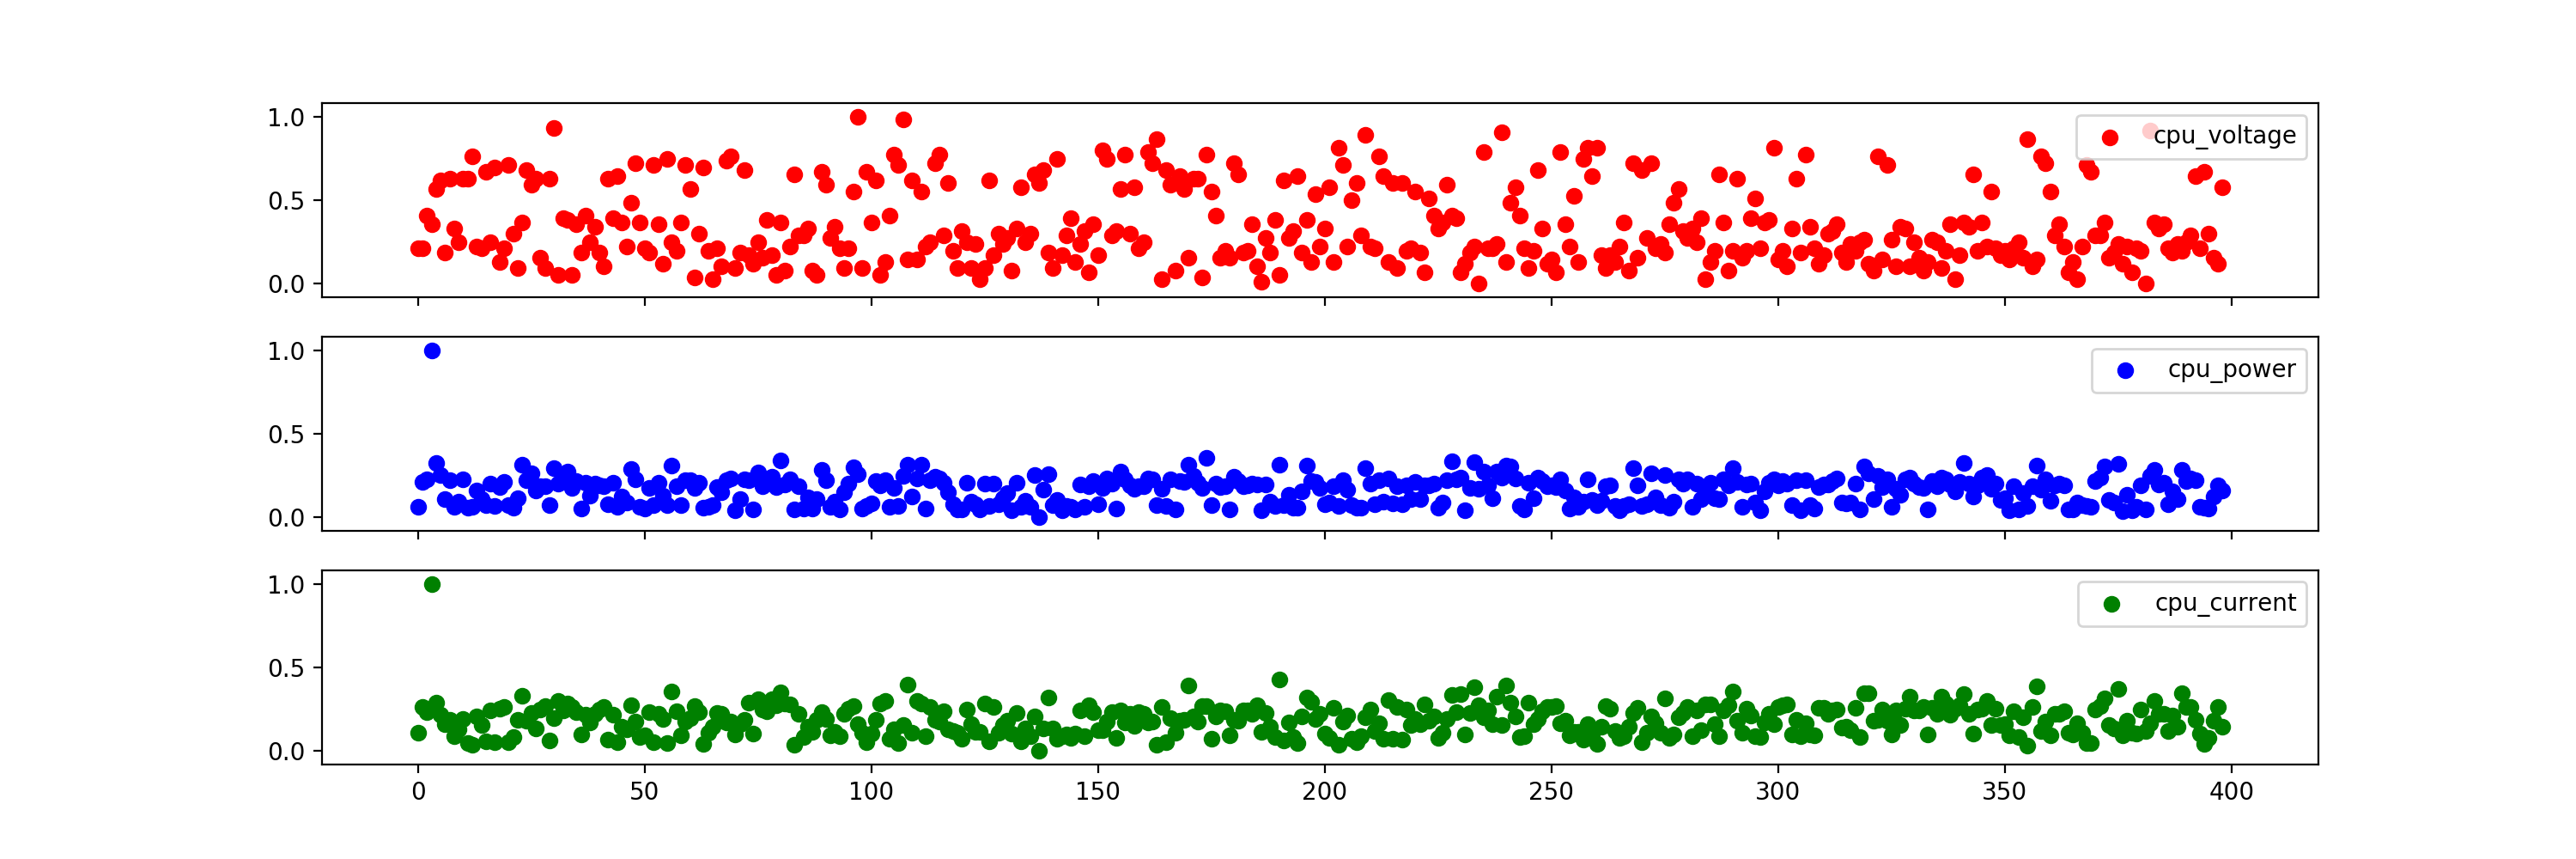

In [70]:
# Visualize CPU Data
# Each feature with its own scatterplot
xvals = range(len(cpu_df.iloc[0]))

fig, ((ax1,ax2,ax3)) = plt.subplots(3,1, sharex=True, sharey=True,figsize=(15,5))
ax1.scatter(list(cpu_df.index), cpu_df["cpu_voltage"], c="red", label=cpu_df.columns[0])
ax2.scatter(list(cpu_df.index), cpu_df["cpu_power"], c="blue", label=cpu_df.columns[1])
ax3.scatter(list(cpu_df.index), cpu_df["cpu_current"], c="green", label=cpu_df.columns[2])
ax1.legend()
ax2.legend()
ax3.legend()

<IPython.core.display.Javascript object>


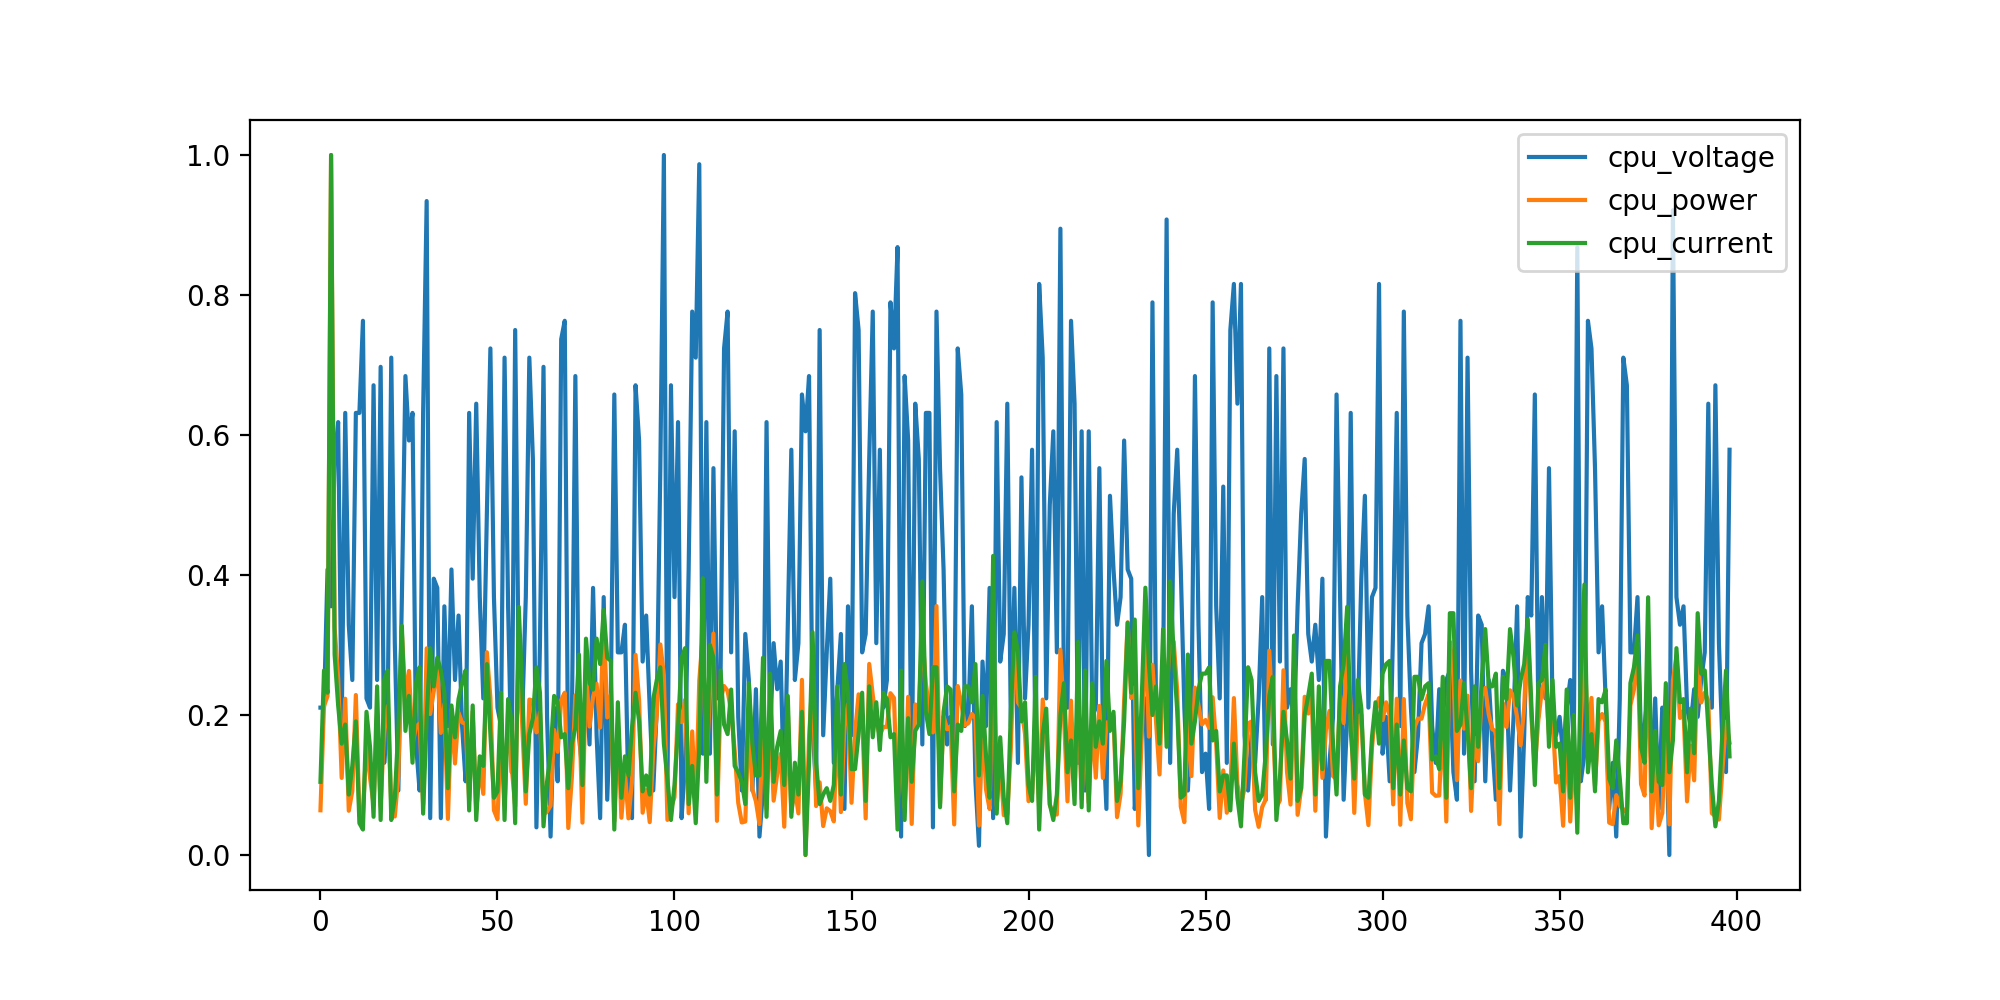

In [71]:
# Linechart of CPU Data
plt.figure(figsize=(10, 5))
plt.plot(cpu_df["cpu_voltage"], label=list(cpu_df.columns)[0])
plt.plot(cpu_df["cpu_power"], label=list(cpu_df.columns)[1])
plt.plot(cpu_df["cpu_current"], label=list(cpu_df.columns)[2])
plt.legend()

## Visualize XTorquer and YTorquer Data


In [72]:
#Normalize data to better visualize it
norm_df = s_df.copy()
columns = list(s_df.columns)

scaler = MinMaxScaler(feature_range=(0, 1))

values = []
for column in columns:
    try:
        norm_df[[column]] = scaler.fit_transform(norm_df[[column]])
    except ValueError:
        values.extend([item for item in norm_df[column]])
norm_df

xtorquer_current  xtorquer_power  xtorquer_voltage  ytorquer_current  \
0               1.000        0.884786          0.567901             1.000   
1               0.000        0.000000          0.098765             0.750   
2               0.625        0.444855          0.456790             0.625   
3               0.125        0.000000          0.000000             0.125   
4               0.125        0.000000          0.000000             0.125   
..                ...             ...               ...               ...   
394             0.375        0.158789          0.271605             0.375   
395             1.000        0.884786          0.567901             0.750   
396             1.000        0.903988          0.580247             0.750   
397             0.375        0.165928          0.283951             0.750   
398             0.125        0.002462          0.012346             0.125   

     ytorquer_power  ytorquer_voltage  cpu_current  cpu_power  cpu_voltage  
0          0.902108          0.567901     0.104541   0.063879     0.210526  
1          0.529367          0.444444     0.263633   0.212776     0.210526  
2          0.453564          0.456790     0.231815   0.227178     0.407895  
3          0.000000          0.000000     1.000000   1.000000     0.355263  
4          0.000000          0.000000     0.286366   0.324971     0.565789  
..              ...               ...          ...        ...          ...  
394        0.022088          0.037037     0.040913   0.055285     0.671053  
395        0.705823          0.592593     0.077275   0.050639     0.302632  
396        0.720633          0.604938     0.177273   0.121951     0.157895  
397        0.691265          0.580247     0.263633   0.190476     0.118421  
398        0.000000          0.000000     0.140912   0.160511     0.578947  

[399 rows x 9 columns]

<IPython.core.display.Javascript object>


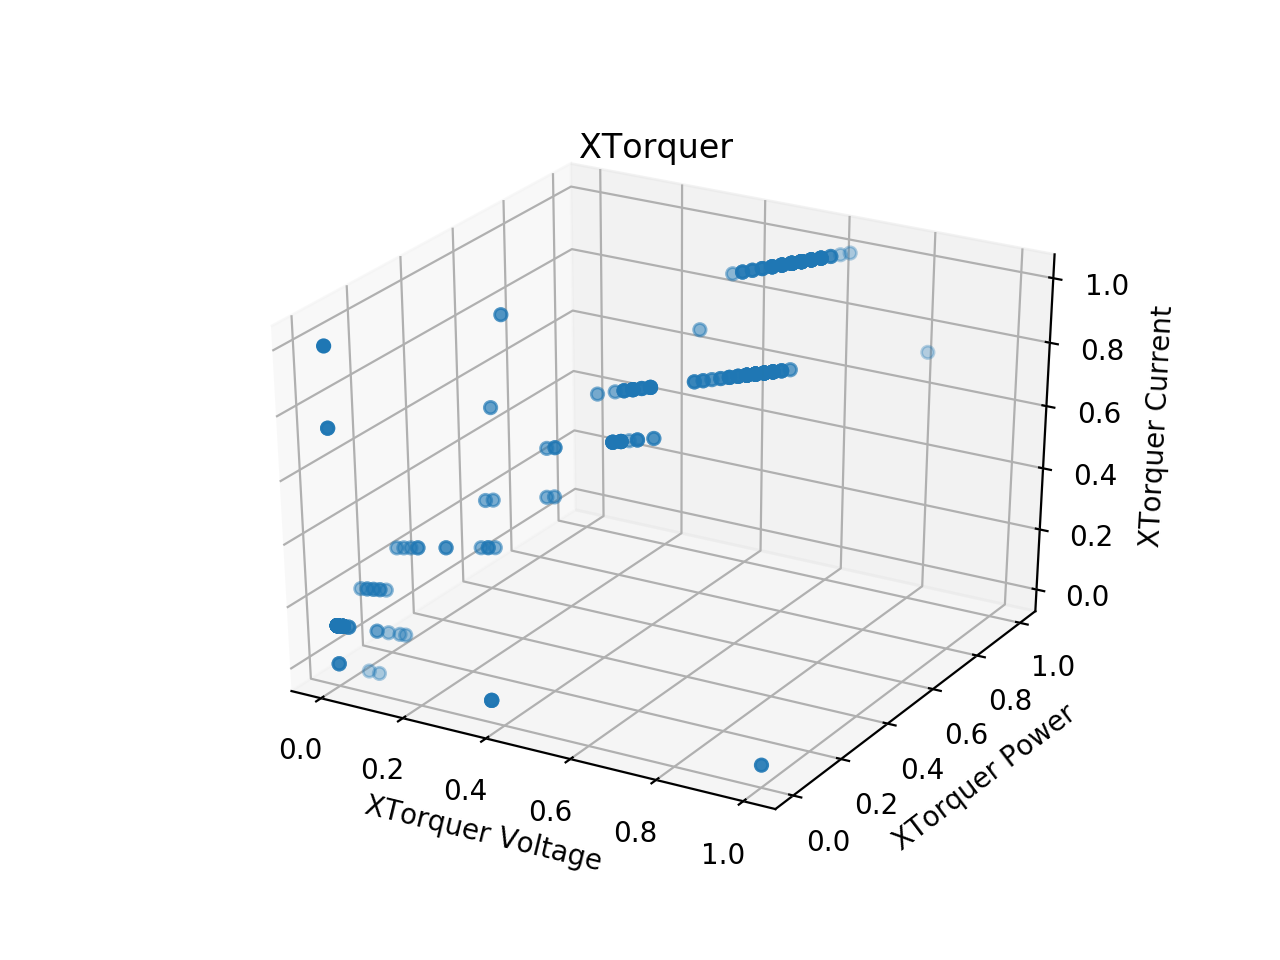

In [73]:
# 3d Scatterplot of XTorquer Data
# this allows plots to appear directly in the notebook
%matplotlib notebook

threedee = plt.figure().gca(projection='3d')
threedee.scatter(norm_df['xtorquer_voltage'], norm_df['xtorquer_power'], norm_df['xtorquer_current'])
threedee.set_xlabel('XTorquer Voltage')
threedee.set_ylabel('XTorquer Power')
threedee.set_zlabel('XTorquer Current')
plt.title('XTorquer')


plt.show()

<IPython.core.display.Javascript object>


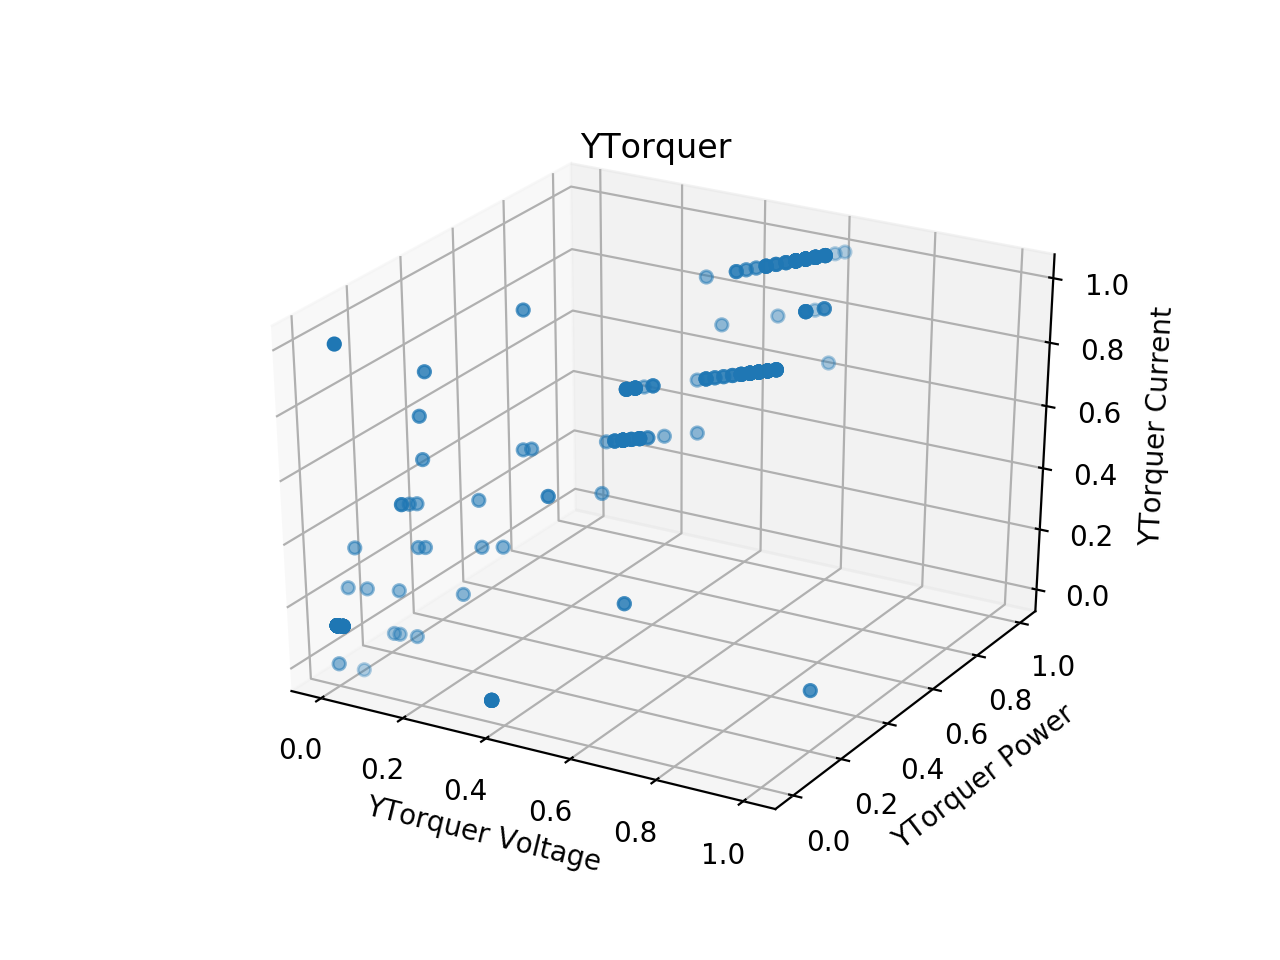

In [74]:
# 3d Scatterplot of YTorquer Data
# this allows plots to appear directly in the notebook
%matplotlib notebook

threedee = plt.figure().gca(projection='3d')
threedee.scatter(norm_df['ytorquer_voltage'], norm_df['ytorquer_power'], norm_df['ytorquer_current'])
threedee.set_xlabel('YTorquer Voltage')
threedee.set_ylabel('YTorquer Power')
threedee.set_zlabel('YTorquer Current')
plt.title('YTorquer')


plt.show()

# 4. Train Isolation Forest Models and analyse results

In [9]:
#Split DF in 2 Dfs, one for YTorquer and one for XTorquer, to train to different models for each of it
# We use the normal data here, not the normalized. Normalized could be used likewise

ytorq = df[['ytorquer_current', 'ytorquer_power','ytorquer_voltage']].copy()
xtorq = df[['xtorquer_current','xtorquer_power','xtorquer_voltage']].copy()
print(xtorq)
ytorq

     xtorquer_current  xtorquer_power  xtorquer_voltage
0            0.125000           359.4            2.8750
1            0.000000             0.0            0.5000
2            0.078125           180.7            2.3125
3            0.015625             0.0            0.0000
4            0.015625             0.0            0.0000
..                ...             ...               ...
394          0.046875            64.5            1.3750
395          0.125000           359.4            2.8750
396          0.125000           367.2            2.9375
397          0.046875            67.4            1.4375
398          0.015625             1.0            0.0625

[399 rows x 3 columns]


ytorquer_current  ytorquer_power  ytorquer_voltage
0            0.125000           359.4            2.8750
1            0.093750           210.9            2.2500
2            0.078125           180.7            2.3125
3            0.015625             0.0            0.0000
4            0.015625             0.0            0.0000
..                ...             ...               ...
394          0.046875             8.8            0.1875
395          0.093750           281.2            3.0000
396          0.093750           287.1            3.0625
397          0.093750           275.4            2.9375
398          0.015625             0.0            0.0000

[399 rows x 3 columns]

In [10]:
## Build isolation forest model for XTorq locally with scikit learn

# Convert dataframe to 2d Array (WML needs array for sending JSON)
rows = [list(r) for i,r in xtorq.iterrows()]
# Create a model (using IsolationForest here with default settings)
clf_x = IsolationForest()
# Place classifier in a sklearn "pipeline"
pipeline_x = Pipeline( steps = [ ( "classifier", clf_x ) ] )
# Fit data to model pipeline
pipeline_x.fit(rows)
# Test model
results_x = pipeline_x.predict(rows)
# Store model results into 'anomaly_score' column
xtorq.loc[: ,'anomaly_score'] = results_x
xtorq


/Users/marcogeiger/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


xtorquer_current  xtorquer_power  xtorquer_voltage  anomaly_score
0            0.125000           359.4            2.8750              1
1            0.000000             0.0            0.5000             -1
2            0.078125           180.7            2.3125              1
3            0.015625             0.0            0.0000              1
4            0.015625             0.0            0.0000              1
..                ...             ...               ...            ...
394          0.046875            64.5            1.3750             -1
395          0.125000           359.4            2.8750              1
396          0.125000           367.2            2.9375              1
397          0.046875            67.4            1.4375             -1
398          0.015625             1.0            0.0625              1

[399 rows x 4 columns]

In [11]:
#Check anomaly classification results for XTorq
xtorq['anomaly_score'].value_counts()

 1    359
-1     40
Name: anomaly_score, dtype: int64

In [12]:
## Build isolation forest model for YTorq locally with scikit learn


# Convert dataframe to 2d Array (WML needs array for sending JSON)
rows = [list(r) for i,r in ytorq.iterrows()]
# Create a model (using IsolationForest here with default settings)
clf_y = IsolationForest()
# Place classifier in a sklearn "pipeline"
pipeline_y = Pipeline( steps = [ ( "classifier", clf_y ) ] )
# Fit data to model pipeline
pipeline_y.fit(rows)
# Test model
results_y = pipeline_y.predict(rows)
# Store model results into 'anomaly_score' column
ytorq.loc[: ,'anomaly_score'] = results_y
ytorq

/Users/marcogeiger/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


ytorquer_current  ytorquer_power  ytorquer_voltage  anomaly_score
0            0.125000           359.4            2.8750              1
1            0.093750           210.9            2.2500              1
2            0.078125           180.7            2.3125              1
3            0.015625             0.0            0.0000              1
4            0.015625             0.0            0.0000              1
..                ...             ...               ...            ...
394          0.046875             8.8            0.1875             -1
395          0.093750           281.2            3.0000              1
396          0.093750           287.1            3.0625              1
397          0.093750           275.4            2.9375              1
398          0.015625             0.0            0.0000              1

[399 rows x 4 columns]

In [13]:
#Check anomaly classification results for YTorq
ytorq['anomaly_score'].value_counts()

 1    359
-1     40
Name: anomaly_score, dtype: int64

In [14]:
# Print overall breakdown of anomalous values vs non-anomalous
from collections import Counter
print(Counter(results_y))


Counter({1: 359, -1: 40})


In [15]:
# ! Just carry out this, if you used the normal data so far!
#Normalize data to better visualize it
norm_xtorq = xtorq.copy()
columns = list(xtorq.columns)

scaler = MinMaxScaler(feature_range=(0, 1))

values = []
for column in list(xtorq.columns):
    if column != "anomaly_score":
        try:
            norm_xtorq[[column]] = scaler.fit_transform(xtorq[[column]])
        except ValueError:
            values.extend([item for item in xtorq[column]])
norm_xtorq

xtorquer_current  xtorquer_power  xtorquer_voltage  anomaly_score
0               1.000        0.884786          0.567901              1
1               0.000        0.000000          0.098765             -1
2               0.625        0.444855          0.456790              1
3               0.125        0.000000          0.000000              1
4               0.125        0.000000          0.000000              1
..                ...             ...               ...            ...
394             0.375        0.158789          0.271605             -1
395             1.000        0.884786          0.567901              1
396             1.000        0.903988          0.580247              1
397             0.375        0.165928          0.283951             -1
398             0.125        0.002462          0.012346              1

[399 rows x 4 columns]

## Analyse Results of XTorquer

<IPython.core.display.Javascript object>


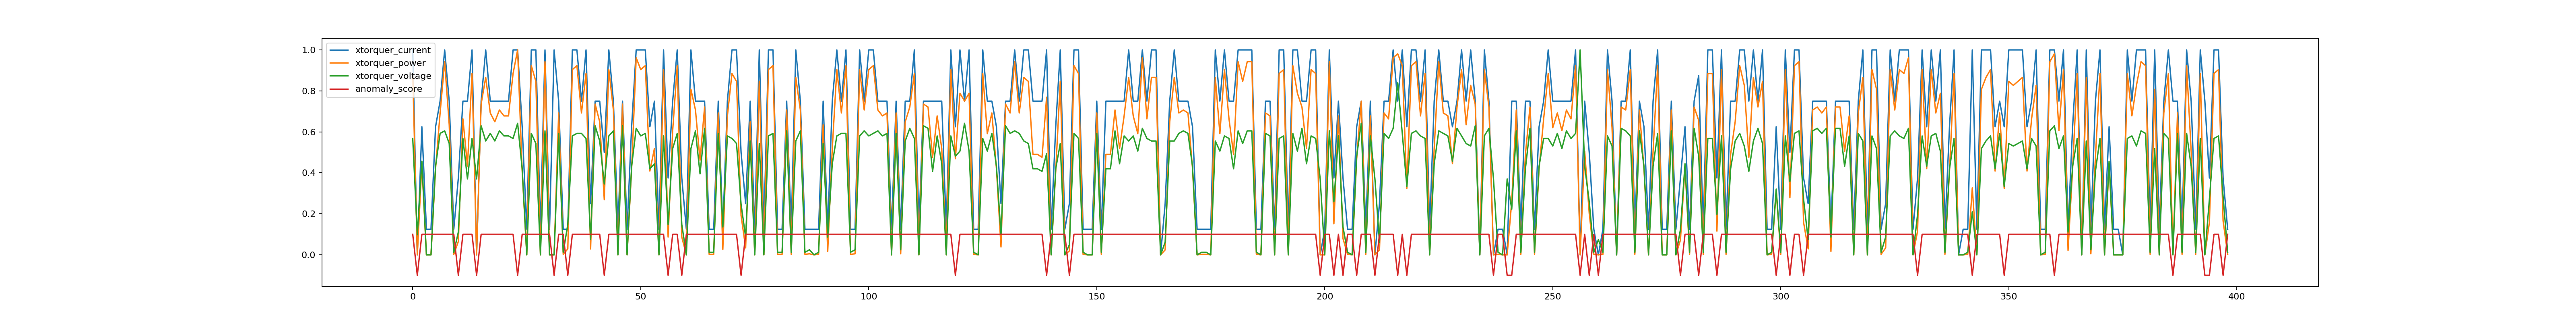

In [85]:
# PLOT RESULTS of the Model
# You have to use the dataframe, you used before 

fig=plt.figure(figsize=(40, 5), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(norm_xtorq["xtorquer_current"], label=list(norm_xtorq.columns)[0])
plt.plot(norm_xtorq["xtorquer_power"], label=list(norm_xtorq.columns)[1])
plt.plot(norm_xtorq["xtorquer_voltage"], label=list(norm_xtorq.columns)[2])
plt.plot(norm_xtorq["anomaly_score"]*0.1, label=list(norm_xtorq.columns)[3])

plt.legend()

<IPython.core.display.Javascript object>


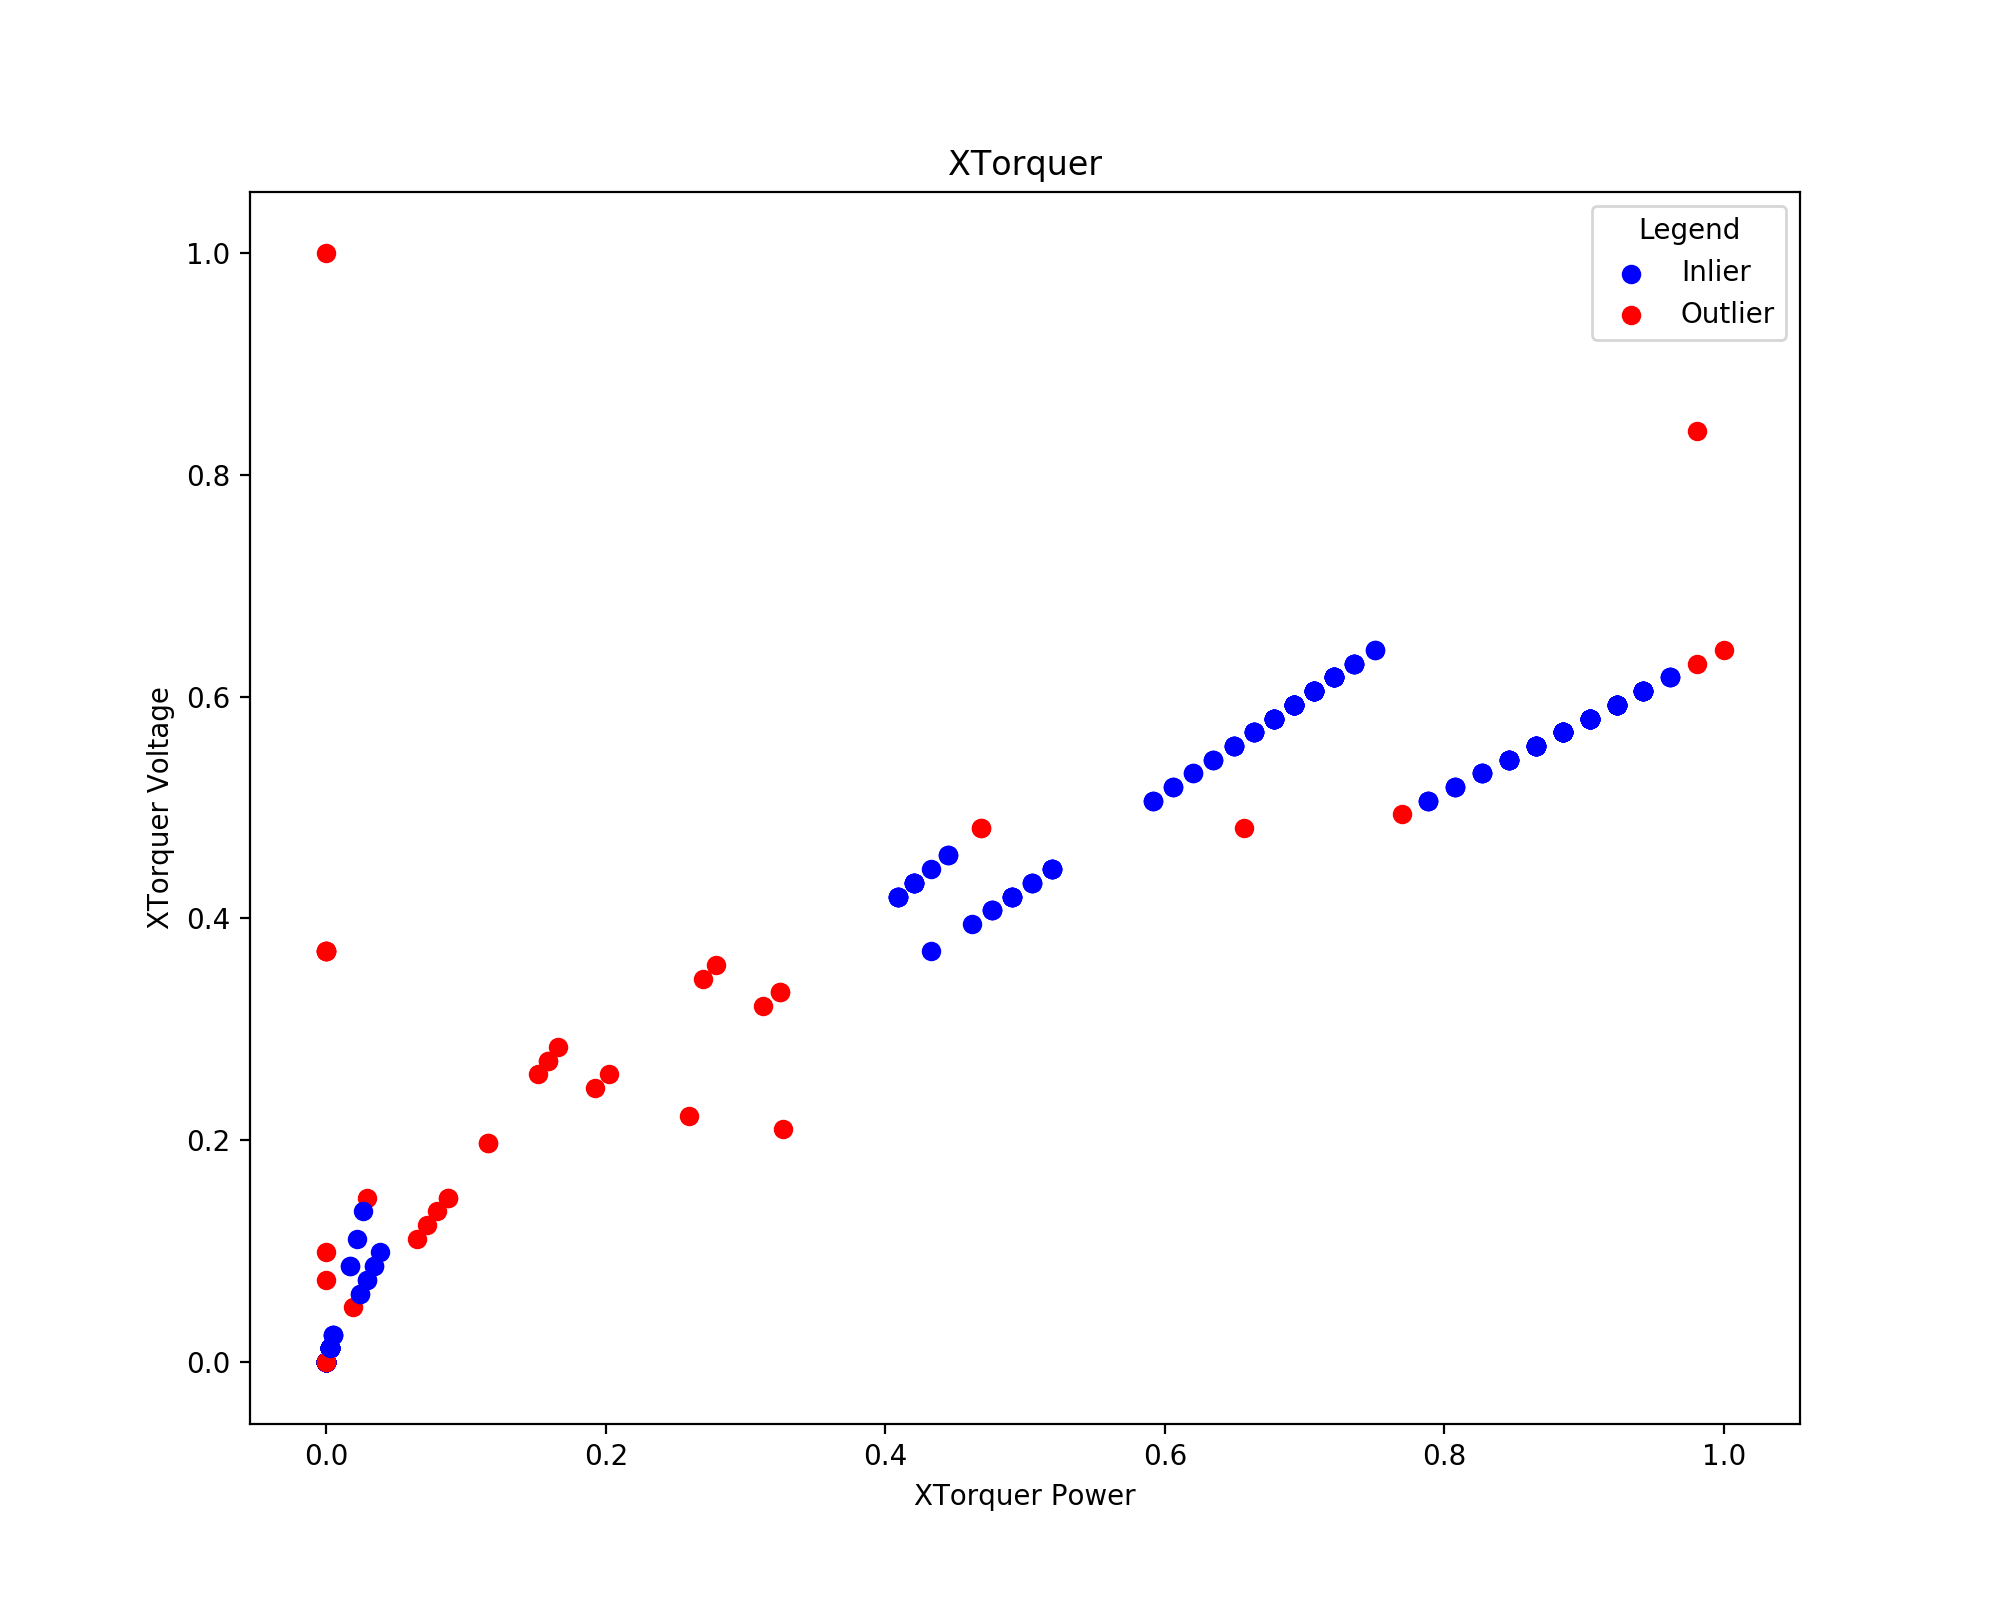

In [86]:
# Plot Scatter of two XTorque Features with Outliers marked in red

plt.figure(figsize=(10, 8))
plt.xlabel("XTorquer Power")
plt.ylabel("XTorquer Voltage")
plt.title('XTorquer')
legend_outlier = 1
for i, row in norm_xtorq.iterrows():
    if row[3] == 1:
        plt.scatter(norm_xtorq.iloc[i]["xtorquer_power"], norm_xtorq.iloc[i]["xtorquer_voltage"], c="blue", label="Inlier" if i == 0 else "")
    else:
        plt.scatter(norm_xtorq.iloc[i]["xtorquer_power"], norm_xtorq.iloc[i]["xtorquer_voltage"], c="red", label="Outlier" if legend_outlier == 1 else "")
        legend_outlier = 0

plt.legend(loc=1, frameon=True, title='Legend')

<IPython.core.display.Javascript object>


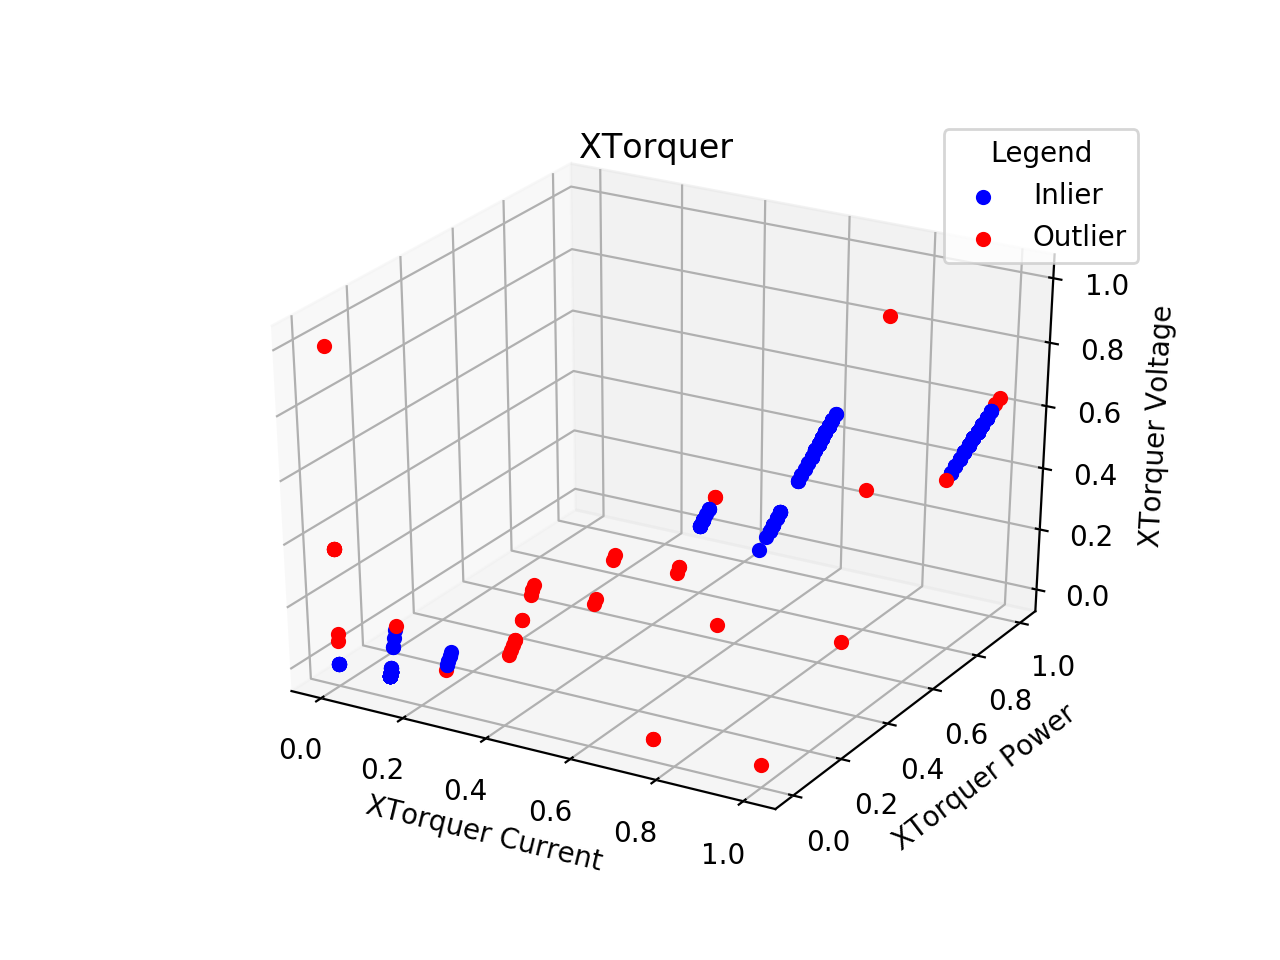

In [87]:
# Plot Scatter of three XTorque Features with Outliers marked in red


# this allows plots to appear directly in the notebook
%matplotlib notebook

vis = plt.figure().gca(projection='3d')
legend_outlier = 1

for i, row in xtorq.iterrows():
    if row[3] == 1:
        vis.scatter(norm_xtorq.iloc[i]['xtorquer_current'], norm_xtorq.iloc[i]['xtorquer_power'], norm_xtorq.iloc[i]['xtorquer_voltage'], c="blue", label="Inlier" if i == 0 else "")
    else:
        vis.scatter(norm_xtorq.iloc[i]['xtorquer_current'], norm_xtorq.iloc[i]['xtorquer_power'], norm_xtorq.iloc[i]['xtorquer_voltage'], c="red", label="Outlier" if legend_outlier == 1 else "")
        legend_outlier = 0
        
vis.set_xlabel('XTorquer Current')
vis.set_ylabel('XTorquer Power')
vis.set_zlabel('XTorquer Voltage')
plt.title('XTorquer')

vis.legend(loc=1, frameon=True, title='Legend')


plt.show()

## Analyse Results of YTorquer

In [88]:
#Normalize data to better visualize it
# ! Just carry out this, if you used the normal data so far!

norm_ytorq = ytorq.copy()
columns = list(ytorq.columns)

scaler = MinMaxScaler(feature_range=(0, 1))

values = []
for column in list(ytorq.columns):
    if column != "anomaly_score":
        try:
            norm_ytorq[[column]] = scaler.fit_transform(ytorq[[column]])
        except ValueError:
            values.extend([item for item in ytorq[column]])
norm_ytorq

ytorquer_current  ytorquer_power  ytorquer_voltage  anomaly_score
0               1.000        0.902108          0.567901              1
1               0.750        0.529367          0.444444              1
2               0.625        0.453564          0.456790              1
3               0.125        0.000000          0.000000              1
4               0.125        0.000000          0.000000              1
..                ...             ...               ...            ...
394             0.375        0.022088          0.037037             -1
395             0.750        0.705823          0.592593              1
396             0.750        0.720633          0.604938              1
397             0.750        0.691265          0.580247              1
398             0.125        0.000000          0.000000              1

[399 rows x 4 columns]

<IPython.core.display.Javascript object>


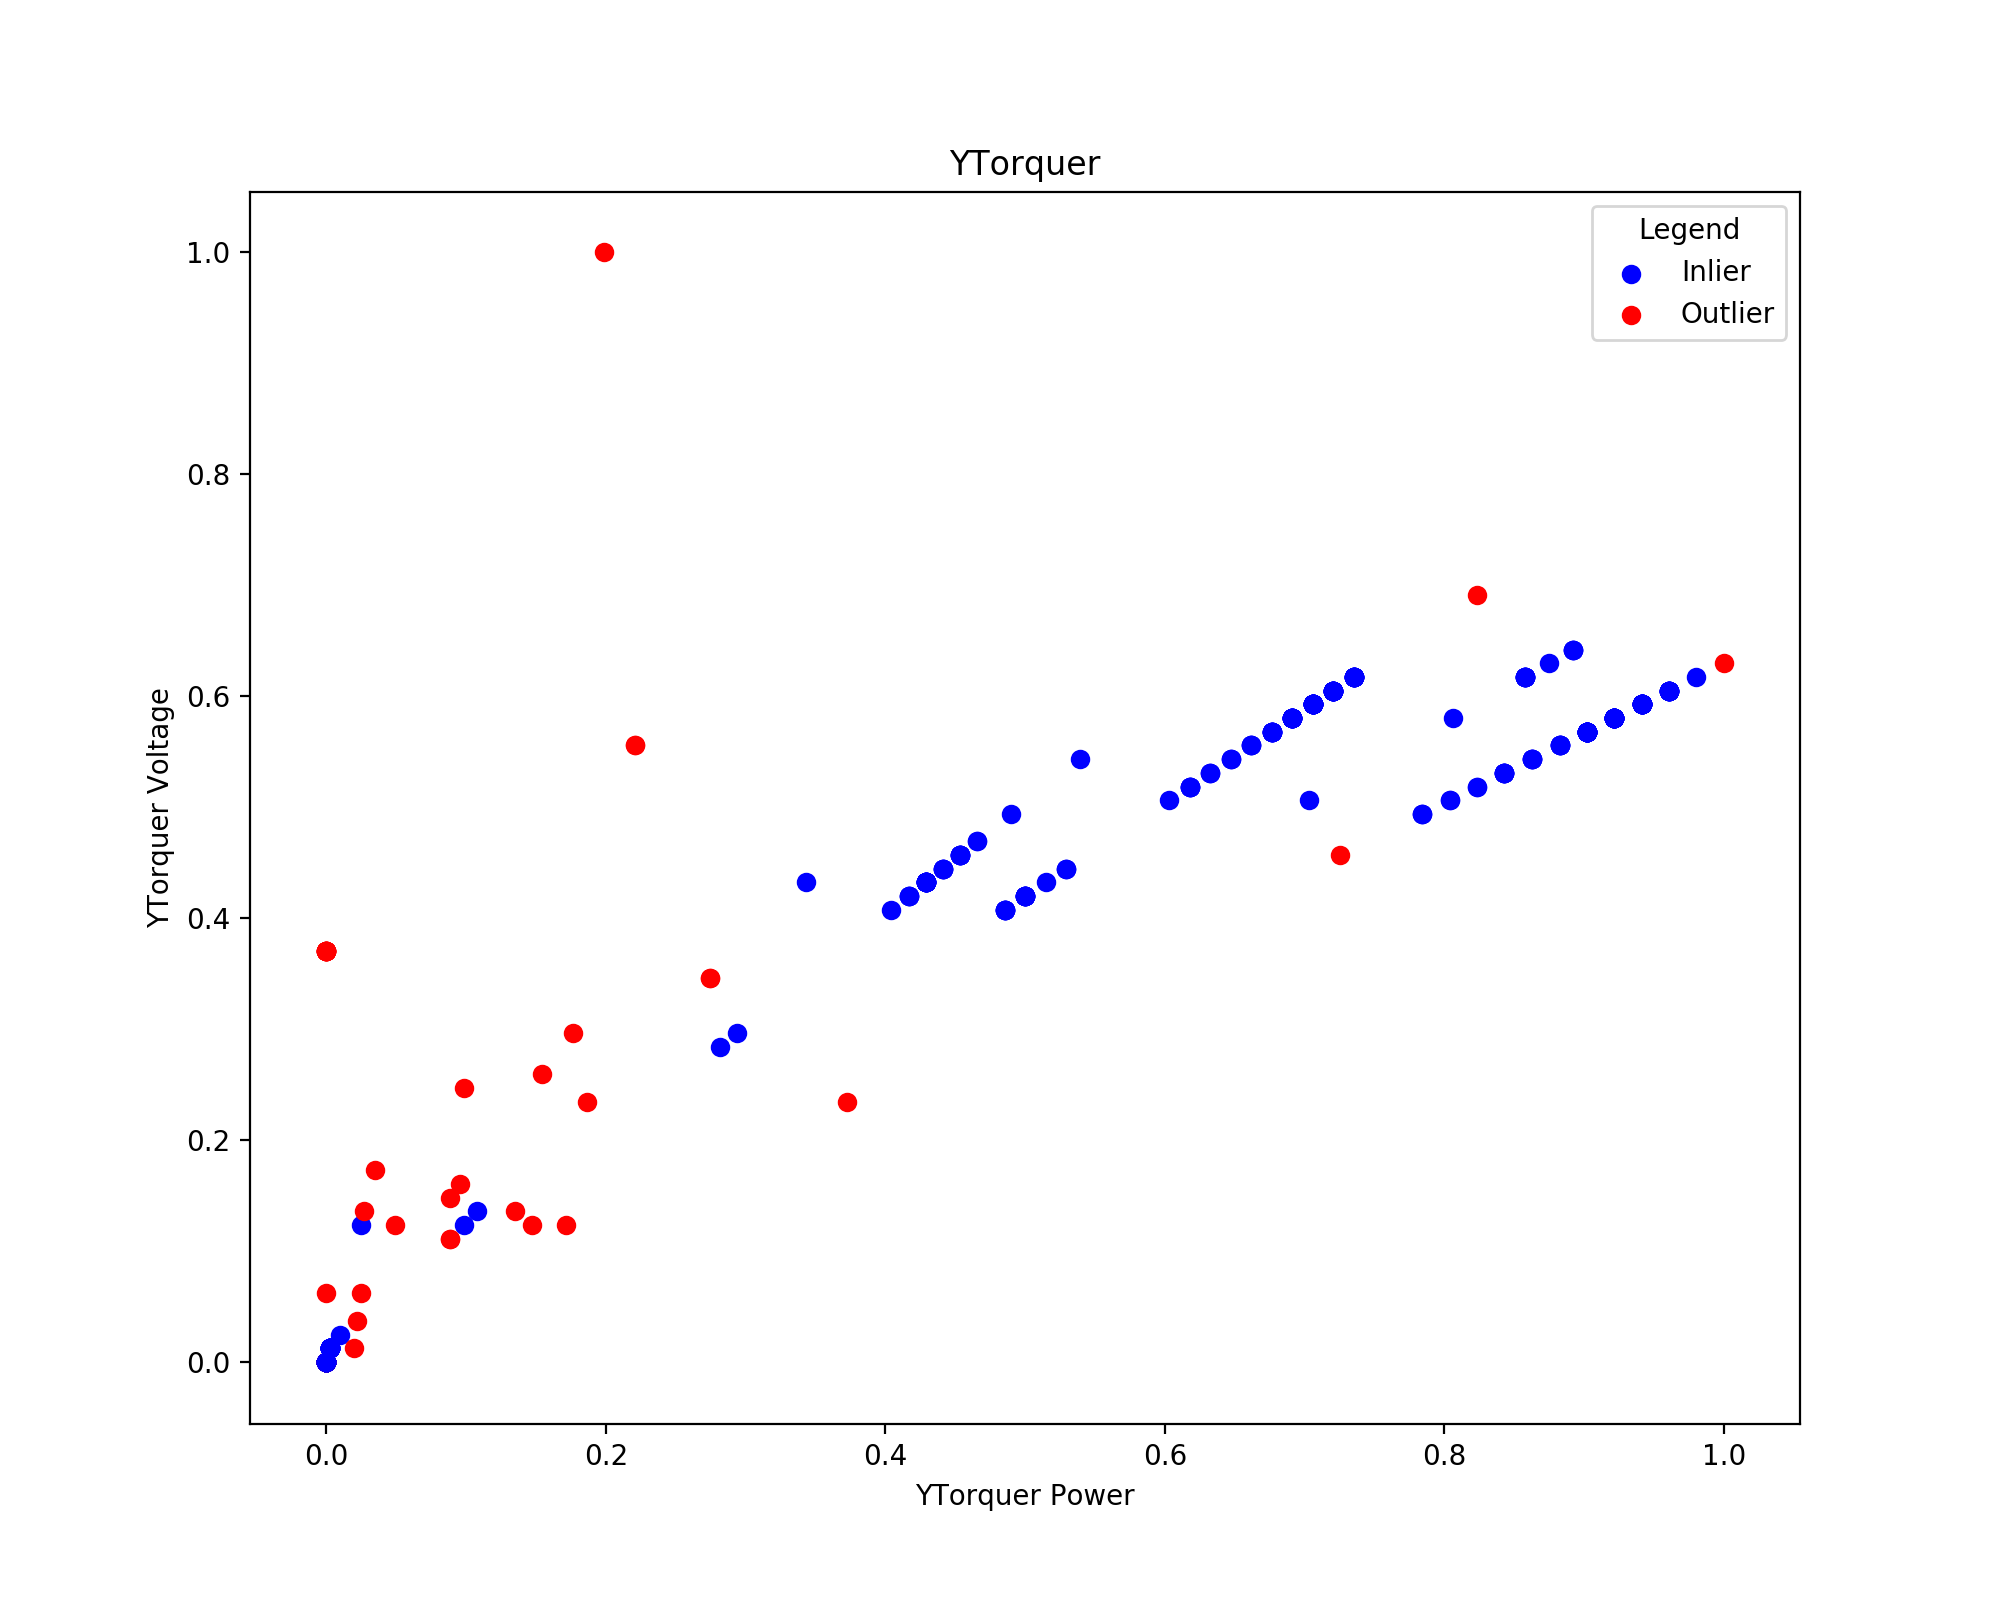

In [89]:
# Plot Scatter of two YTorque Features with Outliers marked in red


plt.figure(figsize=(10, 8))
plt.xlabel("YTorquer Power")
plt.ylabel("YTorquer Voltage")
plt.title('YTorquer')
legend_outlier = 1
for i, row in norm_ytorq.iterrows():
    if row[3] == 1:
        plt.scatter(norm_ytorq.iloc[i]["ytorquer_power"], norm_ytorq.iloc[i]["ytorquer_voltage"], c="blue", label="Inlier" if i == 0 else "")
    else:
        plt.scatter(norm_ytorq.iloc[i]["ytorquer_power"], norm_ytorq.iloc[i]["ytorquer_voltage"], c="red", label="Outlier" if legend_outlier == 1 else "")
        legend_outlier = 0

plt.legend(loc=1, frameon=True, title='Legend')

<IPython.core.display.Javascript object>


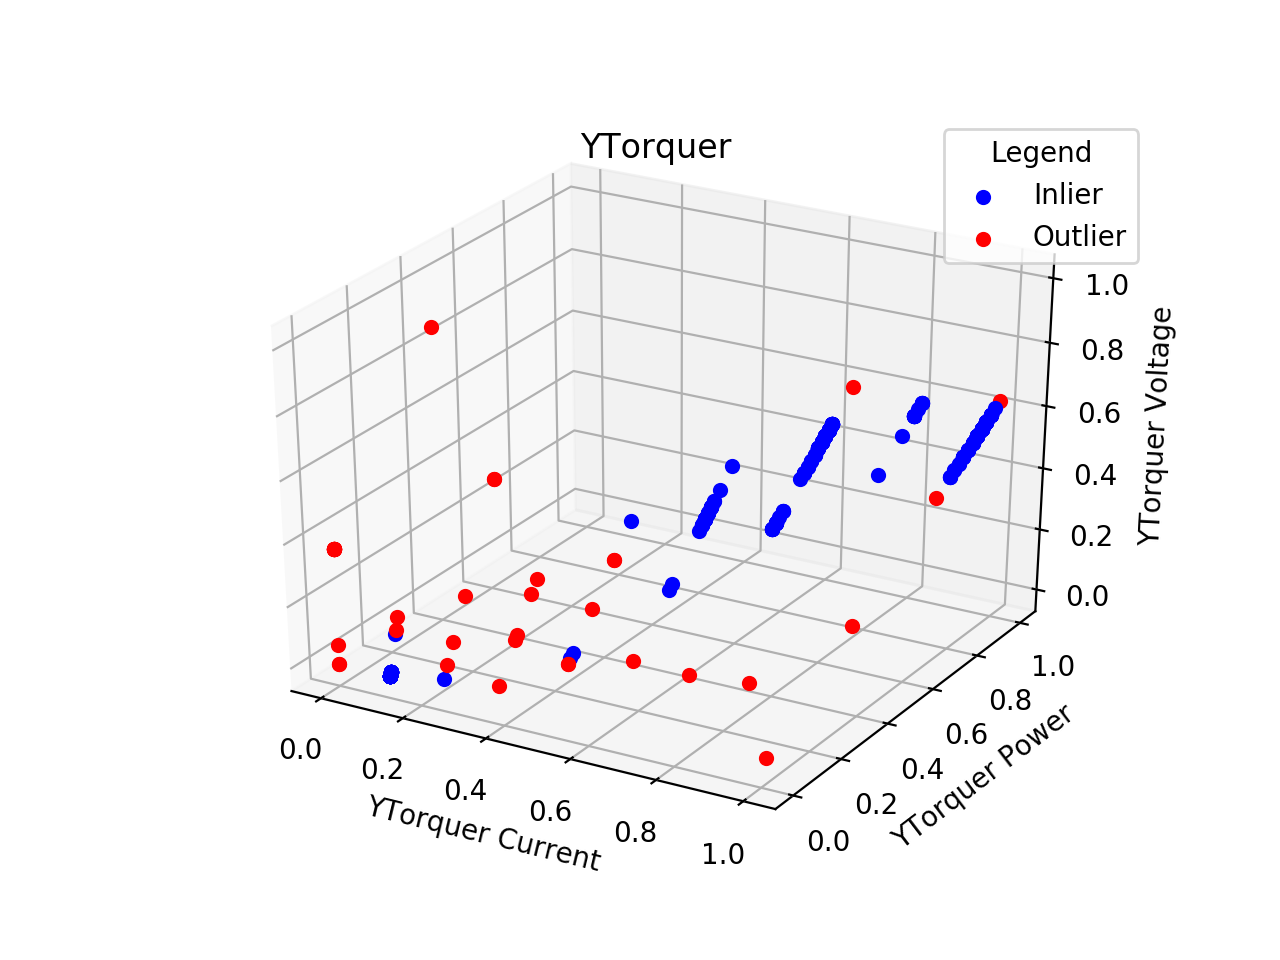

In [90]:
# Plot Scatter of three XTorque Features with Outliers marked in red

# this allows plots to appear directly in the notebook
%matplotlib notebook

vis_y = plt.figure().gca(projection='3d')
legend_outlier_y = 1

for i, row in norm_ytorq.iterrows():
    if row[3] == 1:
        vis_y.scatter(norm_ytorq.iloc[i]['ytorquer_current'], norm_ytorq.iloc[i]['ytorquer_power'], norm_ytorq.iloc[i]['ytorquer_voltage'], c="blue", label="Inlier" if i == 0 else "")
    else:
        vis_y.scatter(norm_ytorq.iloc[i]['ytorquer_current'], norm_ytorq.iloc[i]['ytorquer_power'], norm_ytorq.iloc[i]['ytorquer_voltage'], c="red", label="Outlier" if legend_outlier_y == 1 else "")
        legend_outlier_y = 0
        
vis_y.set_xlabel('YTorquer Current')
vis_y.set_ylabel('YTorquer Power')
vis_y.set_zlabel('YTorquer Voltage')
plt.title('YTorquer')

vis_y.legend(loc=1, frameon=True, title='Legend')


plt.show()

# Publish Model

In [28]:
! pip3 install ibm_watson_machine_learning --user

In [29]:
import sys
!{sys.executable} -m pip install ibm_watson_machine_learning

In [9]:
import sys
!{sys.executable} -m pip list

Package                        Version
------------------------------ ----------
absl-py                        0.9.0
alembic                        1.4.1
appnope                        0.1.0
astor                          0.8.1
attrs                          19.3.0
azure-core                     1.8.0
azure-storage-blob             12.4.0
backcall                       0.2.0
bleach                         3.1.5
certifi                        2019.11.28
cffi                           1.14.2
chardet                        3.0.4
click                          7.1.2
cloudpickle                    1.6.0
combo                          0.0.8
cryptography                   3.1
cycler                         0.10.0
databricks-cli                 0.11.0
decorator                      4.4.1
defusedxml                     0.6.0
dill                           0.3.0
docker                         4.3.1
docutils                       0.15.2
entrypoints                    0.3
feather-format          

In [6]:
# PUBLISH MODEL TO WML
from ibm_watson_machine_learning import APIClient
import json

# USER PREREQ # Update path to WML credentials #
if 'WML_CREDENTIALS_PATH' in os.environ.keys():
    wml_creds_path = os.environ['WML_CREDENTIALS_PATH']
else:
    wml_creds_path = './credentials/wml_credentials.json'

with open(wml_creds_path) as F:
    wml_credentials = json.loads(F.read())
    
client = APIClient(wml_credentials)

if 'project_id' in wml_credentials.keys():
    client.set.default_project(wml_credentials['project_id'])    
if 'space_id' in wml_credentials.keys():
    client.set.default_space(wml_credentials['space_id'])

client.data_assets.list()

Unsetting the project_id ...
----  ----------  ----  --------
NAME  ASSET_TYPE  SIZE  ASSET_ID
----  ----------  ----  --------


In [7]:
wml_credentials

{'url': 'https://us-south.ml.cloud.ibm.com',
 'project_id': '9180069a-e21d-4782-b005-f9162bde8d69',
 'space_id': '11d92d7e-8527-4f74-addc-c7283d294d77',
 'apikey': 'mMMwlZjelJR0gPb1qVQQPVTBDVuS5fcOGoVlYrmqJ6jn'}

In [18]:
# Define ML framework (sklearn, keras, etc)
sk_version = sklearn.__version__
metadata = {
    client.repository.ModelMetaNames.FRAMEWORK_VERSION: 'scikit-learn',
    client.repository.ModelMetaNames.NAME: 'anomaly_model_XTorquer',
    client.repository.ModelMetaNames.RUNTIME_NAME: 'python',
    client.repository.ModelMetaNames.RUNTIME_VERSION: '3.7'
}

# Upload trained model pipeline to WML
model_details_inmem = client.repository.store_model( pipeline_x, meta_props=metadata)
model_id_inmem = model_details_inmem["metadata"]["guid"]
deployment_details_inmem = client.deployments.create( artifact_uid=model_id_inmem, name="anomaly_model_XTorquer" )
deployment_id = deployment_details_inmem["metadata"]["guid"]
model_endpoint_url_inmem = client.deployments.get_scoring_url( deployment_details_inmem )
print("model invocation endpoint: " + model_endpoint_url_inmem)
print("Place below line in .env file like so")

### IMPORTANT, once this is done, take note of the WATSON_ML_DEPLOYMENT_ID
print("WATSON_ML_DEPLOYMENT_ID=" + deployment_id) # TODO, need to confirm notebook will reload .env file. Or just change from .env to mem


AttributeError: 'ModelMetaNames' object has no attribute 'FRAMEWORK_VERSION'

In [43]:
sofware_spec_uid = client.software_specifications.get_id_by_name("scikit-learn_0.20-py3.6")

metadata = {
            client.repository.ModelMetaNames.NAME: 'anomaly_model_YTorquer',
            client.repository.ModelMetaNames.TYPE: 'scikit-learn_0.20',
            client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: sofware_spec_uid
}

published_model = client.repository.store_model(
    model=pipeline_y,
    meta_props=metadata)


2020-10-31 12:07:01,129 - ModelCollection - DEBUG - 
Creating a new scikit pipeline model: anomaly_model_YTorquer

2020-10-31 12:07:02,646 - ibm_watson_machine_learning.libs.repo.swagger_client.rest - DEBUG - 
response body: {
  "entity": {
    "software_spec": {
      "id": "09c5a1d0-9c1e-4473-a344-eb7b665ff687",
      "name": "scikit-learn_0.20-py3.6"
    },
    "type": "scikit-learn_0.20"
  },
  "metadata": {
    "created_at": "2020-10-31T11:07:02.478Z",
    "id": "4a5dddff-24cb-42af-a491-f5488b4a62b5",
    "modified_at": "2020-10-31T11:07:02.478Z",
    "name": "anomaly_model_YTorquer",
    "owner": "IBMid-50JXV3M326",
    "space_id": "11d92d7e-8527-4f74-addc-c7283d294d77"
  }
}

2020-10-31 12:07:02,904 - ModelCollection - INFO - 
In case , where space_id is passed.

2020-10-31 12:07:02,904 - ModelCollection - INFO - 
In case , where space_id is passed.

2020-10-31 12:07:05,768 - ModelCollection - DEBUG - 
Content uploaded for model version created at: 4a5dddff-24cb-42af-a491-f5488

In [8]:
client.set.default_space('11d92d7e-8527-4f74-addc-c7283d294d77')

'SUCCESS'

In [45]:
model_uid = client.repository.get_model_uid(published_model)
model_uid

'4a5dddff-24cb-42af-a491-f5488b4a62b5'

In [46]:
models_details = client.repository.list_models()

------------------------------------  ----------------------  ------------------------  -----------------
ID                                    NAME                    CREATED                   TYPE
4a5dddff-24cb-42af-a491-f5488b4a62b5  anomaly_model_YTorquer  2020-10-31T11:07:02.002Z  scikit-learn_0.20
a8b6f23a-91ec-4513-a281-931458fcadd1  anomaly_model_XTorquer  2020-10-31T10:47:55.002Z  scikit-learn_0.20
------------------------------------  ----------------------  ------------------------  -----------------


In [9]:
# Print deployments
client.deployments.list()

------------------------------------  -------------------  ------  ------------------------
GUID                                  NAME                 STATE   CREATED
9ceb7e48-6099-42e2-aa48-9453179d8c87  YTorquer_Deployment  ready   2020-10-31T11:09:25.089Z
1a052e80-9f05-4884-8790-4ec051d29244  YTorquer_Deployment  ready   2020-10-31T11:07:52.724Z
1de58f9d-190e-4989-aa45-2ddc91b60527  XTorquer_Deployment  ready   2020-10-31T10:52:28.565Z
97b74840-5637-4383-8961-9b440c52bd6d  XTorquer_Deployment  failed  2020-10-31T10:49:44.179Z
------------------------------------  -------------------  ------  ------------------------


In [52]:
scoring_payload = {client.deployments.ScoringMetaNames.INPUT_DATA:
       [{'fields':
           ["ytorquer_current", 
            "ytorquer_power", 
            "ytorquer_voltage"],
           'values': [
           [ 0.015625,5.9, 0.375], 
            [0.09375, 187.5, 2.0]           
           ]      
        }    
       ]}

In [59]:
deployment_id = '9ceb7e48-6099-42e2-aa48-9453179d8c87'

In [60]:
predictions = client.deployments.score(deployment_id, scoring_payload)
predictions

{'predictions': [{'fields': ['prediction'], 'values': [[1], [1]]}]}

In [58]:
metadata = {
    client.deployments.ConfigurationMetaNames.NAME: "YTorquer_Deployment",
    client.deployments.ConfigurationMetaNames.ONLINE: {}
}

created_deployment = client.deployments.create(model_uid, meta_props=metadata)



#######################################################################################

Synchronous deployment creation for uid: '4a5dddff-24cb-42af-a491-f5488b4a62b5' started

#######################################################################################


initializing
ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='9ceb7e48-6099-42e2-aa48-9453179d8c87'
------------------------------------------------------------------------------------------------




In [8]:
## Publish function to Maximo Monitor, in order to use it in your entity
## Make sure to set the correct name of the function, which matches the name of the class in /custom/function.py

from custom.functions import SatelliteXTorquerModelv4
entity_name = 'Satellite'
db.register_functions([SatelliteXTorquerModelv4], force_preinstall=True)


2020-10-31 13:20:06,697 - iotfunctions.db - DEBUG - 
<module 'custom.functions' from '/Users/marcogeiger/GitHub/Satellite_AnomalyDetection/custom/functions.py'> is preinstalled False

2020-10-31 13:20:06,697 - iotfunctions.base - DEBUG - 
Looking for item values for {'name': 'input_items', 'type': 'DATA_ITEM', 'dataType': 'ARRAY', 'dataTypeForArray': ['NUMBER'], 'required': True, 'description': 'Data items adjust', 'tags': [], 'jsonSchema': {'$schema': 'http://json-schema.org/draft-07/schema#', 'type': 'array', 'minItems': 1, 'maxItems': None, 'items': {'type': 'string'}}}

2020-10-31 13:20:06,698 - iotfunctions.base - DEBUG - 
Looking for item values for {'name': 'wml_endpoint', 'type': 'CONSTANT', 'dataType': 'LITERAL', 'description': 'Endpoint to WML service where model is hosted', 'tags': ['TEXT'], 'required': True, 'values': None}

2020-10-31 13:20:06,698 - iotfunctions.base - DEBUG - 
Looking for item values for {'name': 'deployment_id', 'type': 'CONSTANT', 'dataType': 'LITERAL'

''

In [8]:
## Publish function to Maximo Monitor, in order to use it in your entity
## Make sure to set the correct name of the function, which matches the name of the class in /custom/function.py

from custom.functions import SatelliteYTorquerModel
entity_name = 'Satellite'
db.register_functions([SatelliteYTorquerModel], force_preinstall=True)


2020-10-31 12:31:15,006 - iotfunctions.db - DEBUG - 
<module 'custom.functions' from '/Users/marcogeiger/GitHub/Satellite_AnomalyDetection/custom/functions.py'> is preinstalled False

2020-10-31 12:31:15,008 - iotfunctions.base - DEBUG - 
Looking for item values for {'name': 'input_items', 'type': 'DATA_ITEM', 'dataType': 'ARRAY', 'dataTypeForArray': ['NUMBER'], 'required': True, 'description': 'Data items adjust', 'tags': [], 'jsonSchema': {'$schema': 'http://json-schema.org/draft-07/schema#', 'type': 'array', 'minItems': 1, 'maxItems': None, 'items': {'type': 'string'}}}

2020-10-31 12:31:15,008 - iotfunctions.base - DEBUG - 
Looking for item values for {'name': 'wml_endpoint', 'type': 'CONSTANT', 'dataType': 'LITERAL', 'description': 'Endpoint to WML service where model is hosted', 'tags': ['TEXT'], 'required': True, 'values': None}

2020-10-31 12:31:15,009 - iotfunctions.base - DEBUG - 
Looking for item values for {'name': 'instance_id', 'type': 'CONSTANT', 'dataType': 'LITERAL', 

''

In [12]:
# Print deployments
client.deployments.list()

------------------------------------  -------------------  ------  ------------------------
GUID                                  NAME                 STATE   CREATED
9ceb7e48-6099-42e2-aa48-9453179d8c87  YTorquer_Deployment  ready   2020-10-31T11:09:25.089Z
1a052e80-9f05-4884-8790-4ec051d29244  YTorquer_Deployment  ready   2020-10-31T11:07:52.724Z
1de58f9d-190e-4989-aa45-2ddc91b60527  XTorquer_Deployment  ready   2020-10-31T10:52:28.565Z
97b74840-5637-4383-8961-9b440c52bd6d  XTorquer_Deployment  failed  2020-10-31T10:49:44.179Z
------------------------------------  -------------------  ------  ------------------------


In [14]:
# Define the columns for the function, you want to register
# Change the columns for ytorquer accordingly
columns = ['xtorquer_current', 'xtorquer_power', 'xtorquer_voltage']

In [13]:
deployment_id = '1de58f9d-190e-4989-aa45-2ddc91b60527'

In [16]:
# Invoke function in monitor
WATSON_ML_ENDPOINT = wml_credentials['url']
WATSON_ML_INSTANCE_ID = wml_credentials['space_id']
WATSON_ML_APIKEY = wml_credentials['apikey']
WATSON_ML_DEPLOYMENT_ID=deployment_id

entity = EntityType(
                entity_name, 
                db,
                SatelliteXTorquerModel(
                                wml_endpoint=WATSON_ML_ENDPOINT,
                                instance_id=WATSON_ML_INSTANCE_ID,
                                deployment_id=WATSON_ML_DEPLOYMENT_ID,
                                apikey=WATSON_ML_APIKEY,
                                input_items=columns
                ),
                **{
                  '_timestamp' : 'evt_timestamp',
                  '_db_schema' : db_schema}
)
entity.exec_local_pipeline()



2020-10-31 12:49:47,810 - root - DEBUG - 
Initializing

2020-10-31 12:49:47,842 - root - DEBUG - 
sorted input_items ['xtorquer_current', 'xtorquer_power', 'xtorquer_voltage']

2020-10-31 12:49:47,848 - iotfunctions.metadata - DEBUG - 
Initializing new entity type using iotfunctions 2.0.3

2020-10-31 12:49:47,853 - iotfunctions.util - DEBUG - 
Starting trace

2020-10-31 12:49:47,855 - iotfunctions.util - DEBUG - 
Trace name: auto_trace_Satellite_20201031114947

2020-10-31 12:49:47,856 - iotfunctions.util - DEBUG - 
auto_save None

2020-10-31 12:49:47,859 - iotfunctions.util - DEBUG - 
categorizing arguments

2020-10-31 12:49:47,872 - iotfunctions.db - DEBUG - 
Table name = SATELLITE , self.metadata = MetaData(bind=Engine(db2+ibm_db://bluadmin:***@db2w-wxdibox.us-south.db2w.cloud.ibm.com:50001/BLUDB;SECURITY=ssl;))  
/Users/marcogeiger/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sqlalchemy/sql/base.py:299: SAWarning: Can't validate argument '_db_schema'; can't locate any SQLAlche


2020-10-31 12:49:49,938 - iotfunctions.pipeline - INFO - 
  System generated DropNull stage

2020-10-31 12:49:49,939 - iotfunctions.pipeline - DEBUG - 
-------------------------------

2020-10-31 12:49:49,940 - iotfunctions.pipeline - WARNING - 
Skipped due to dependency issue

2020-10-31 12:49:49,940 - iotfunctions.pipeline - WARNING - 
Skipped due to dependency issue

2020-10-31 12:49:49,941 - iotfunctions.pipeline - WARNING - 
StageException

2020-10-31 12:49:49,941 - iotfunctions.pipeline - WARNING - 
StageException

2020-10-31 12:49:49,942 - iotfunctions.pipeline - WARNING - 
Skipped due to dependency issue

2020-10-31 12:49:49,942 - iotfunctions.pipeline - WARNING - 
Skipped due to dependency issue

2020-10-31 12:49:49,942 - iotfunctions.pipeline - WARNING - 
NoneType: None


2020-10-31 12:49:49,942 - iotfunctions.pipeline - WARNING - 
NoneType: None


2020-10-31 12:49:49,944 - iotfunctions.pipeline - WARNING - 
Execution aborted

2020-10-31 12:49:49,944 - iotfunctions.pipeline 

TBD ***** - Add stages for usage stats


RuntimeError: Execution was aborted: None
 Skipped due to dependency issue
NoneType: None

